In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
import os
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('movies_metadata.csv')
ratings=pd.read_csv('ratings_small.csv')
links=pd.read_csv('links_small.csv')
keywords=pd.read_csv('keywords.csv')
credit=pd.read_csv('credits.csv')

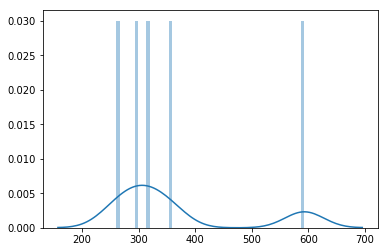

In [19]:
import seaborn as sns
most_common=list(ratings.movieId.value_counts().head().index)
sns.distplot(most_common,bins=50)

In [38]:
def convert_id(x):
    try:
        return int(x)
    except:
        return None

df['id']=df['id'].apply(convert_id)
df=df[df['id'].notnull()]

In [39]:
def update_genres(dfi):
    dfi=dfi.copy()
    
    dfi['genres'] =dfi ['genres'].fillna('[]')\
    .apply(literal_eval)\
    .apply(lambda x: [i['name'] for i in x]\
          if isinstance(x, list) else [])

    temp = dfi.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
    temp.name = 'genre'
    dfi = dfi.drop('genres', axis=1).join(temp)
    return dfi

# Popularity Voting

In [8]:
# calculate imdb rating
def calc_imdb_rating(row,m,c):
    v=row['vote_count']
    r=row['vote_average']
    return round(v/(v+m)*r+m/(v+m)*c,1)

In [9]:
#%% popularity voting
'''
- v is the number of votes for the movie
- m is the minimum votes required to be listed in the chart
- R is the average rating of the movie
- C is the mean vote across the whole report
weighted_average=v/(v+m)*r+m/(v+m)*c
'''
def rec_popularity(df):
    df_cur=df[df['vote_count'].notnull()][df['vote_average'].notnull()]
    df_cur['vote_count']=df_cur['vote_count'].astype(int)
    df_cur['vote_average']=df_cur['vote_average'].astype(float)
    df_cur_clean=df_cur[(df_cur['vote_count'].notnull()) & (df_cur['vote_average'].notnull())]
    m=df_cur_clean['vote_count'].quantile(0.95) #must have more votes than at least 95% of movies on the list
    c=np.average(df_cur_clean['vote_average'],weights=df_cur_clean['vote_count'])
    print('average score',round(c,1),'# of votes',m)
    df_cur['weighted_rating']=df_cur.apply(lambda row:calc_imdb_rating(row,m,c),axis=1)
    
    df_cur_sorted=df_cur.sort_values(['weighted_rating','vote_count'],ascending=[0,0])
    cols_to_print=['title','weighted_rating','vote_count','vote_average']
    results=df_cur_sorted[cols_to_print].head(10)
    return results

def rec_popularity_genres(genre,df):
    temp=df[df['genre']==genre]
    return rec_popularity(temp)


In [10]:
# recommendation in general
results1=rec_popularity(df)
print('popular items\n')
print(results1)

average score 6.7 # of votes 434.0
popular items

                          title  weighted_rating  vote_count  vote_average
314    The Shawshank Redemption              8.4        8358           8.5
834               The Godfather              8.4        6024           8.5
12481           The Dark Knight              8.2       12269           8.3
2843                 Fight Club              8.2        9678           8.3
292                Pulp Fiction              8.2        8670           8.3
522            Schindler's List              8.2        4436           8.3
23673                  Whiplash              8.2        4376           8.3
15480                 Inception              8.1       14075           8.1
351                Forrest Gump              8.1        8147           8.2
1154    The Empire Strikes Back              8.1        5998           8.2


In [13]:
# feature engineering
df_genres=update_genres(df)

In [14]:
# recommendation for a gerne
results2=rec_popularity_genres('Drama',df_genres)
print('popular DRAMA\n')
print(results2)

average score 7.0 # of votes 384.0
popular DRAMA

                             title  weighted_rating  vote_count  vote_average
314       The Shawshank Redemption              8.4        8358           8.5
834                  The Godfather              8.4        6024           8.5
12481              The Dark Knight              8.3       12269           8.3
10309  Dilwale Dulhania Le Jayenge              8.3         661           9.1
2843                    Fight Club              8.2        9678           8.3
522               Schindler's List              8.2        4436           8.3
23673                     Whiplash              8.2        4376           8.3
2211             Life Is Beautiful              8.2        3643           8.3
1178        The Godfather: Part II              8.2        3418           8.3
22879                 Interstellar              8.1       11187           8.1


# Content-based recommendation

Part 1: predicton based on description of the movie 

Description includes: overview and tagline
distance metric: cosine similarity:
    TF-IDF Vectorizer is used, calculating the Dot Product will directly give us the Cosine Similarity Score. 
    linear_kernel is used instead of cosine_similarities as it's much faster.

In [40]:
# create distance metric
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
def create_matrix(df,variable):
    tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
    tfidf_matrix = tf.fit_transform(df[variable])
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    df_indexed=df.copy()
    df_indexed['index']=df.index.tolist()
    return cosine_sim,df_indexed

In [41]:
def get_recommendations(title,df,cosine_sim):
    idx=df[df['title']==title]['index'].iloc[0]
    results=df.copy()
    results['score']=cosine_sim[idx].tolist()
    
    results=results.sort_values('score',ascending=0).head(20)
    return results

In [42]:
# similarity matrix of overview
dfx=df.copy()
dfx['description']=dfx['overview'].fillna('').astype(str)+' '+df['tagline'].fillna('').astype(str)
cosine_sim,df_content=create_matrix(dfx,'description')
del dfx

In [43]:
# recommendation results
for title in ['Toy Story','The Dark Knight','The Godfather']:
    results=get_recommendations(title,df_content,cosine_sim)
    cols_to_print=['title','vote_average','score']
    print('######',title,'\n',results[cols_to_print])

###### Toy Story 
                                               title  vote_average     score
0                                         Toy Story           7.7  1.000000
2997                                    Toy Story 2           7.3  0.241413
15348                                   Toy Story 3           7.6  0.214426
24523                                     Small Fry           6.8  0.111579
10301                        The 40 Year Old Virgin           6.2  0.109526
23843                   Andy Hardy's Blonde Trouble           6.3  0.102047
8327                                      The Champ           6.8  0.101142
43427              Andy Kaufman Plays Carnegie Hall           0.0  0.090910
3057                                Man on the Moon           6.9  0.089616
38476  Superstar: The Life and Times of Andy Warhol           0.0  0.087913
42721  Andy Peters: Exclamation Mark Question Point           0.0  0.083118
29202                                    Hot Splash           4.0  0.

In [71]:
# for a user, recommend items that they may be interesting, without knowing what the user is currently looking at yet
# 1) find top 3 rated items, 2) each item, find most similar items
def recommend_fresh(userid,ratings,df,n=3):
    ratings=ratings[ratings['userId']==userid].sort_values(['rating','timestamp'],ascending=[1,1]).head(3)
    results=pd.DataFrame()
    for title in df[df['id'].isin(ratings['movieId'])]['title'].tolist():
        print('###### user liked',title)
        resultsi=get_recommendations(title,df,cosine_sim)
        results=results.append(resultsi)
        print(resultsi['title'].tolist())
    results=results.drop_duplicates()


In [72]:
recommend_fresh(1,ratings,df_content)

###### user liked Jay and Silent Bob Strike Back
['Jay and Silent Bob Strike Back', "Jay And Silent Bob's Super Groovy Cartoon Movie", 'Saving Mr. Banks', 'Peacock', 'An Evening with Kevin Smith', 'Scrawl', 'Chasing Amy', 'Easy Riders, Raging Bulls', 'Double Dare', 'Sunset Boulevard', 'Hellboy: The Seeds of Creation', "Comic-Con Episode IV: A Fan's Hope", 'The Low Life', 'Look, Up in the Sky: The Amazing Story of Superman', 'Comic Book: The Movie', 'Born to Win', 'Danger: Diabolik', 'Sesame Street Presents Follow That Bird', 'Puckoon', 'The Movies']
###### user liked Greed
['Greed', 'Foolish Wives', 'Rick and Morty: State of Georgia Vs. Denver Fenton Allen', 'The Fisher King', "Merlin's Apprentice", 'Lucky', 'The Secret Glory', 'Zézero', 'The Visual Bible: The Gospel of John', 'Hollywood', 'The N Word', 'Captain Thunder', 'I Was an Adventuress', 'Berlin Alexanderplatz', '1812', 'City Lights', 'The Seventh Sign', 'Twin Peaks: Fire Walk with Me - The Missing Pieces', 'The Student Prince 

Part 2: predicton based on meta-data of the movie

Meta-data includes: director, cast (top 4), keywords
distance metric: CountVectorizer implements both tokenization and count of occurrence. 

why TfidfVectorizer?
    several common words makes up lot of space which carry very little information about content of document.
    If we feed these counts directly to a classifier then those frequently occurring words will shadow the real interesting terms of the document.
  
why CountVectorizer() instead of TF-IDF?
    This is because you do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [ ]:
# feature engineering (meta-data)
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
def select_most_freq_keyword(keywords):
    keywords['keywords']=keywords['keywords'].fillna('[]')\
    .apply(literal_eval)\
    .apply(lambda x: [i['name'] for i in x]\
           if isinstance(x,list) else [])
    
    # unroll all keywords per instance and find most frequent one
    tmp=keywords.apply(lambda x:pd.Series(x['keywords']),axis=1).stack().reset_index(level=1,drop=True)
    tmp_count=tmp.value_counts()
    freq_words=tmp_count[tmp_count>1].index.tolist()
    print('out of',len(tmp_count),'keywords',len(freq_words),'are selected')
    
    def filter_keywords(x,freq_words):
        stemmer=SnowballStemmer('english')
        words=[]
        for i in x:
            if i in freq_words:
                word_cur=''.join([stemmer.stem(word.lower()) for word in word_tokenize(i)])
                words.append(word_cur)
        return words
    keywords['keywords_new']=keywords['keywords'].apply(lambda x: filter_keywords(x,freq_words))
    return keywords

def select_director_cast(b):
    #get director, two-step: 1) lower case, 2) remove blank
    def get_director(x):
        for i in x:
            if i['job']=='Director':
                return i['name'].replace(' ','').lower() 
        return ''
    
    b['director']=b['crew'].fillna('[]').apply(literal_eval).apply(get_director)
    b['director']
    
    b['cast']=b['cast'].fillna('[]').apply(literal_eval)\
    .apply(lambda x: [i['name'].lower().replace(' ','') for i in x] if isinstance(x, list) else [])
    #pick the top 4
    b['cast']=b['cast'].apply(lambda x:x[:3] if len(x)>3 else x)
    return b
    
keywords=select_most_freq_keyword(keywords)
credit=select_director_cast(credit)

df_all=df.copy()
df_all=df_all.merge(keywords[['keywords_new','id']],on='id')\
.merge(credit[['id','director','cast']],on='id')

df_all['vars']=df_all.apply(lambda x:' '.join(x['genres']\
      +x['keywords_new']\
      +[x['director']]*2\
      +x['cast']),axis=1)


In [ ]:
# create distance metric
def create_matrix_count(df,variable):
    ct = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
    tfidf_matrix = ct.fit_transform(df[variable])
    #cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    
    df_indexed=df.copy()
    df_indexed['index']=df.index.tolist()
    return cosine_sim,df_indexed

In [ ]:
# find similarity matrix based on meta-data
cosine_sim2,df_content2=create_matrix_count(df_all,'vars')

In [ ]:
for title in ['Toy Story']:#,'The Dark Knight','The Godfather']:
    results=get_recommendations(title,df_content2,cosine_sim)
    print('######',title,'\n',results)

# Collaborative filtering

In [20]:
#%% collaborative filtering
from surprise import Reader, Dataset, SVD, KNNBasic, evaluate,accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
import time

In [21]:
# read in data
reader = Reader(rating_scale=(0,5))#(rating_scale=(ratings.min(),ratings.max()))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

model selection

Grid Search: evaluate each model and see which one predicts the best
- KNN method
- SVD method

KNN method (use item-item based)

In [53]:
# grid search to find best score plus cross-validation
from surprise.model_selection import GridSearchCV
options={'name': ['cosine','pearson_baseline','msd','pearson'],'user_based': [False]}
param_grid = {'sim_options': options,'k': [10,20,30,40],'verbose':[True]} #'sim_options': options,
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

results_df = pd.DataFrame.from_dict(gs.cv_results)
print(results_df)

# use the best estimator as the final model
model_final = gs.best_estimator['rmse']

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done 

In [ ]:
# test the results
trainset=data.build_full_trainset()
testset=trainset.build_testset()

predictions = model_final.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

SVD method (use item-item based)

In [24]:
# grid search to find best score plus cross-validation
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors':[10,20,50],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(T)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

results_df_svd = pd.DataFrame.from_dict(gs.cv_results)
print(results_df_svd)

# use the best estimator as the final model
model_final_svd = gs.best_estimator['rmse']

0.9141128789617975
{'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}
    split0_test_rmse  split1_test_rmse  split2_test_rmse  mean_test_rmse  \
0           0.947298          0.949168          0.943639        0.946702   
1           0.953221          0.955340          0.948866        0.952475   
2           0.926176          0.928019          0.923399        0.925864   
3           0.933623          0.935773          0.929978        0.933125   
4           0.930225          0.932258          0.927709        0.930064   
5           0.937379          0.939623          0.933884        0.936962   
6           0.914317          0.915863          0.912159        0.914113   
7           0.922820          0.924591          0.919564        0.922325   
8           0.947394          0.949329          0.943939        0.946887   
9           0.953357          0.955423          0.949037        0.952605   
10          0.926269          0.928074          0.923464        0.925936   
11

In [25]:
# test the results
trainset=data.build_full_trainset()
testset=trainset.build_testset()

predictions = model_final_svd.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.8837
MAE:  0.6858


0.685782838755112

#### if only use one algorithm, and cross validate this one

In [95]:
# single method, cross_validation to evaluate score
from surprise.model_selection import validation
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

model=KNNBasic(sim_options={'name':'pearson_baseline'})
#evaluate(model, data, measures=['RMSE', 'MAE'])
validation.cross_validate(model, data, measures=[u'rmse', u'mae'], 
                          cv=5, return_train_measures=False,
                          n_jobs=1, verbose=False)

def split_data(data):
    from surprise.model_selection import train_test_split        
    # sample random trainset and testset
    # test set is made of 25% of the ratings.
    trainset, testset = train_test_split(data, test_size=.25)
    return trainset, testset

def whole_data(data):
    trainset=data.build_full_trainset()
    testset=trainset.build_testset()
    return trainset, testset

# split data
trainset, testset=split_data(data)
predictions = model.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

# whole data
trainset, testset=whole_data(data)
predictions = model.fit(trainset).test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9964
MAE:  0.7689
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.3760
MAE:  0.2630


0.2630012628207597

split data before launching the algorithm

In [97]:
data.split(n_folds=3)
model=KNNBasic(sim_options={'name':'pearson_baseline'})
evaluate(model, data, measures=['RMSE', 'MAE'])

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0124
MAE:  0.7796
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0138
MAE:  0.7828
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0113
MAE:  0.7804
------------
------------
Mean RMSE: 1.0125
Mean MAE : 0.7809
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [1.012405981903362,
                             1.013807542269437,
                             1.0112931810851185],
                            'mae': [0.7796309392309435,
                             0.7827605104993606,
                             0.7804190641265616]})

In [26]:
# give rating to the top n picks
def rate_topn(uid,dfx,model):
    for ind,row in dfx.iterrows():
        score=model.predict(uid,int(row['id'])).est
        dfx.set_value(ind,'cb_score',score)
    return dfx

In [122]:
# train-test consistency
predictions=model_final.test(trainset.build_testset())

In [109]:
print(predictions[2]) # print the second indexed user & item, their results
print(model_final.predict(1,1061))

[Prediction(uid=1, iid=1061, r_ui=3.0, est=2.578009364916735, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=1, iid=1129, r_ui=2.0, est=2.4733788220804764, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=1, iid=1172, r_ui=4.0, est=2.6665340725786093, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=1, iid=1263, r_ui=2.0, est=2.429273260273908, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=1, iid=1287, r_ui=2.0, est=2.5571401906891844, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=1, iid=1293, r_ui=2.0, est=2.442047246798517, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=1, iid=1339, r_ui=3.5, est=2.587278887904752, details={'actual_k': 20, 'was_impossible': False}), Prediction(uid=1, iid=1343, r_ui=2.0, est=2.534092565720418, details={'actual_k': 20, 'was_impossible': False})]
user: 1          item: 1061       r_ui = None   est = 2.58   {'actual_k': 20, 'was_impossibl

# Hybrid Method

In [119]:
# cf will use average ratings of the training set if (movie) or (user) does not exist in the training dataset

In [120]:
def hybrid_method(title,userid,df,cosine_sim,cf_model):
    # step 1: recommend similar items to user's current selection
    results=get_recommendations(title,df,cosine_sim)
    # step 2: suggest top picks based on assumed rating of the user
    results=rate_topn(userid,results,cf_model)
    # step 3: output the results
    results=results.sort_values(['cb_score','score'],ascending=[0,0])\
    .rename(columns={'cb_score':'predicted_rating','score':'similarity'})\
    [['title','vote_average','predicted_rating','similarity']]
    
    return results

In [121]:
hybrid_method('Batman Returns',4,df_content,cosine_sim,model_final)

,title,vote_average,predicted_rating,similarity
1328,Batman Returns,6.6,4.755942,1.000000
150,Batman Forever,5.2,4.155449,0.070592
12481,The Dark Knight,8.3,3.924325,0.090491
25267,Batman vs Dracula,6.5,3.543608,0.151451
15511,Batman: Under the Red Hood,7.6,3.543608,0.129254
21194,Batman Unmasked: The Psychology of the Dark Kn...,8.0,3.543608,0.126443
18252,The Dark Knight Rises,7.6,3.543608,0.122640
41982,Batman Beyond Darwyn Cooke's Batman 75th Anniv...,7.7,3.543608,0.120516
41976,The Lego Batman Movie,7.2,3.543608,0.114206
40974,LEGO DC Comics Super Heroes: Batman: Be-Leaguered,6.1,3.543608,0.111119


# the end

In [ ]:
def k_fold_ontrain(data):
    from surprise.model_selection import KFold
    kf = KFold(n_splits=3)
    algo = SVD()
    for trainset, testset in kf.split(data):
        # train and test algorithm.
        algo.fit(trainset)
        predictions = algo.test(testset)
        # Compute and print Root Mean Squared Error
        print(accuracy.rmse(predictions, verbose=True))
        print(accuracy.mae(predictions, verbose=True))

k_fold_ontrain(data)